# COMP 551 - Mini Project 2 (Group 60)
**In this project, we implement Naive Bayes and K-fold cross-validation from scratch and use logistic regression from the scikit-learn package.  The goal is to compare these two algorithms on two distinct textual datasets.**

In [2]:
import numpy as np
import string
import pandas as pd # use Pandas to preprocess the data
from sklearn.decomposition import PCA, KernelPCA
import seaborn as sn
# the output of plotting commands is displayed inline within frontends
%matplotlib inline                                  
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from IPython.core.debugger import set_trace # for debugging

# dataset processing
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

# sklearn models
from sklearn.linear_model import LogisticRegression

# set the seed for reproducibility
np.random.seed(1234)

## Task 1: Acquire and preprocess the data

The first task is to acquire the data and clean it. To turn the text data into numerical feature, you should use the bags of words representation using the scikit-learn function CountVectorizer2 for more details on the function.

### 2O news group dateset:

In [3]:
remove=(['headers', 'footers', 'quotes'])
newsgroup_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=77, remove=remove)
newsgroup_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=77, remove=remove)

print(newsgroup_train.target_names)
print(len(newsgroup_train.data))
# print(newsgroup_train.data[0]) # print the first data 
print(newsgroup_train.target_names[newsgroup_train.target[0]]) # print the category of the first data instance

newsgroup_X_train = newsgroup_train.data
newsgroup_Y_train = newsgroup_train.target
newsgroup_X_test = newsgroup_test.data
newsgroup_Y_test = newsgroup_test.target

# Data preprocessing order: raw data -> clean punctuation -> CountVectorizer to calculate word occurence -> tf–idf to calculate frequency -> TruncatedSVD to reduce dimensionality (LSA: latent semantic analysis) -> ready to use by model

# clean punctuation like: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
cleaner = str.maketrans('', '', string.punctuation)
map(lambda x : x.translate(cleaner), newsgroup_X_train)
map(lambda x : x.translate(cleaner), newsgroup_X_test)

# Convert the text data into numerical feature vector using CountVectorizer function
# (make word occurrence as features value)
CV = CountVectorizer()
newsgroup_X_train_occurrence = CV.fit_transform(newsgroup_X_train)
newsgroup_X_test_occurrence = CV.transform(newsgroup_X_test)
# X_train_counts is a matrix where rows: data instances, columns: words, values in matrix (Mij): corresponding word occurence in the given data instance 
print(newsgroup_X_train_occurrence.shape)
print(newsgroup_X_test_occurrence.shape)

# Convert occurence to frequency (since longger documents (data) will have higher occurence of words)
# using tf–idf (“Term Frequency times Inverse Document Frequency”) which will convert occurrence of words to frequency and scale down the impact of words that occur very frequently in a given corpus that are less informative (Ex: "is", "it", "a", "the", etc)
newsgroup_tfidf_transformer = TfidfTransformer(use_idf=True)
# fit the transformer to our data and transform our occurrence data matrix to tfidf matrix
newsgroup_X_train_tfidf = newsgroup_tfidf_transformer.fit_transform(newsgroup_X_train_occurrence)
newsgroup_X_test_tfidf = newsgroup_tfidf_transformer.transform(newsgroup_X_test_occurrence)
print(newsgroup_X_train_tfidf.shape)
print(newsgroup_X_test_tfidf.shape)

# use SVD to do dimensionality reduction (LSA: latent semantic analysis)
svd = TruncatedSVD(n_components=500, n_iter=7, random_state=77)
newsgroup_X_train_tfidf = svd.fit_transform(newsgroup_X_train_tfidf)
newsgroup_X_test_tfidf = svd.transform(newsgroup_X_test_tfidf)

# Scale word frequency to [0,1], since negative value cannot be feed to MultinomialNB
# The output of scaler.transform() will be nparray
scaler = MinMaxScaler()
newsgroup_X_train_tfidf = scaler.fit_transform(newsgroup_X_train_tfidf)
newsgroup_X_test_tfidf = scaler.transform(newsgroup_X_test_tfidf)
print(newsgroup_X_train_tfidf.shape)
print(newsgroup_X_test_tfidf.shape)





['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314
rec.sport.hockey
(11314, 101631)
(7532, 101631)
(11314, 101631)
(7532, 101631)
(11314, 500)
(7532, 500)


### IMDB dateset:

In [4]:
IMDB_train_df = pd.read_csv('./IMDB_training.csv')
IMDB_test_df = pd.read_csv('./IMDB_testing.csv')

# ramdomize the data order
IMDB_train_df = IMDB_train_df.sample(frac=1).reset_index(drop=True)
IMDB_test_df = IMDB_test_df.sample(frac=1).reset_index(drop=True)
# print(IMDB_train_df)

# Data preprocessing order: raw data -> clean punctuation -> CountVectorizer to calculate word occurence -> tf–idf to calculate frequency -> TruncatedSVD to reduce dimensionality (LSA: latent semantic analysis) -> ready to use by model

# clean punctuation like: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
cleaner = str.maketrans('', '', string.punctuation)
IMDB_train_df['Text'] = IMDB_train_df['Text'].apply(lambda x : x.translate(cleaner)) 
IMDB_test_df['Text'] = IMDB_test_df['Text'].apply(lambda x : x.translate(cleaner)) 

# convert panda dataframe type to numpy array
array_train_IMDB = IMDB_train_df.to_numpy() # clean dataset in numpy array format
array_test_IMDB = IMDB_test_df.to_numpy()
IMDB_X_train, IMDB_Y_train = array_train_IMDB[:,0], array_train_IMDB[:,1].astype(int) # split the dataset to data and label
IMDB_X_test, IMDB_Y_test = array_test_IMDB[:,0], array_test_IMDB[:,1].astype(int) # split the dataset to data and label

# Convert the text data into numerical feature vector using CountVectorizer function
# (make word occurrence as features value)
CV = CountVectorizer()
IMDB_X_train_occurrence = CV.fit_transform(IMDB_X_train)
IMDB_X_test_occurrence = CV.transform(IMDB_X_test)
# X_train_counts is a matrix where rows: data instances, columns: words, values in matrix (Mij): corresponding word occurence in the given data instance 
print(IMDB_X_train_occurrence.shape)
print(IMDB_X_test_occurrence.shape)

# Convert occurence to frequency (since longer documents (data) will have higher occurence of words)
# using tf–idf (“Term Frequency times Inverse Document Frequency”) which will convert occurrence of words to frequency and scale down the impact of words that occur very frequently in a given corpus that are less informative (Ex: "is", "it", "a", "the", etc)
IMBD_tfidf_transformer = TfidfTransformer(use_idf=True)
# fit the transformer to our data and transform our occurrence data matrix to tfidf matrix
IMDB_X_train_tfidf = IMBD_tfidf_transformer.fit_transform(IMDB_X_train_occurrence)
IMDB_X_test_tfidf = IMBD_tfidf_transformer.transform(IMDB_X_test_occurrence)
print(IMDB_X_train_tfidf.shape)
print(IMDB_X_test_tfidf.shape)

# use SVD to do dimensionality reduction (LSA: latent semantic analysis)
svd = TruncatedSVD(n_components=500, n_iter=7, random_state=77) 
IMDB_X_train_tfidf = svd.fit_transform(IMDB_X_train_tfidf)
IMDB_X_test_tfidf = svd.transform(IMDB_X_test_tfidf)

# Scale word frequency to [0,1], since negative value cannot be feed to MultinomialNB
# The output of scaler.transform() will be nparray
scaler = MinMaxScaler()
IMDB_X_train_tfidf = scaler.fit_transform(IMDB_X_train_tfidf)
IMDB_X_test_tfidf = scaler.transform(IMDB_X_test_tfidf)
print(IMDB_X_train_tfidf.shape)
print(IMDB_X_test_tfidf.shape)

(25000, 120674)
(25000, 120674)
(25000, 120674)
(25000, 120674)
(25000, 500)
(25000, 500)


## Task 2: Implement Naive Bayes and k-fold cross validation

Two main tasks:
1. Implement naive Bayes, using the appropriate type of likelihood for features.
2. Implementing k-fold cross validation.

**Evaluate accuracy function:**

In [5]:
# this function will take the true labels (i.e. ground truth), and target labels (i.e. predictions) as input, and output the accuracy score
def evaluate_acc(trueLabel, targetLabel):
    accuracy = np.sum(targetLabel == trueLabel)/trueLabel.shape[0] # calculate the accuracy
    return accuracy

### Task 2.1: Naive Bayes

In [7]:
def logsumexp(Z):  # dimension C x N
    Zmax = np.max(Z,axis=0)[None,:]                              # max over C
    log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
    return log_sum_exp

from scipy.sparse import csr_matrix, isspmatrix

class MultinomialNB:

    def logsumexp(Z):  # dimension C x N
        Zmax = np.max(Z, axis=0)[None, :]  # max over C
        log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
        return log_sum_exp

    def __init__(self, alpha=1):
        self.alpha=alpha
        return

    def fit(self, x, y):
        self.x, self.y = x, y
        self.N, self.D = x.shape
        self.C = np.max(y) + 1

        Nc = np.zeros(self.C)

        loglikelihood = np.zeros((self.C, self.D))

        for c in range(self.C):
            x_c = x[y == c]  # slice all the elements from class c
            Nc[c] = x_c.shape[0]  # get number of elements of class c
            # sum of the occurrences divided by the total counts in documents of class C
            loglikelihood[c] = np.log((np.sum(x_c, axis=0) + self.alpha) / (np.sum(np.sum(x_c, axis=0)) + (self.alpha*self.D)))

        self.likelihoods = loglikelihood
        log_prior = np.log(Nc / self.N)
        self.log_prior = log_prior
        return self.log_prior, self.likelihoods

    def predict(self, test_x):

        labels = np.zeros((test_x.shape[0], self.C))  # N x C array
        
        for i, curr_x in enumerate(test_x):
            #use scipy sparse package for efficiency if sparse input 
            if isspmatrix(curr_x):
              curr_x = csr_matrix(curr_x)
            for c in range(self.C):
                likelihood = curr_x.dot(self.likelihoods[c])
                labels[i][c] = np.sum(likelihood)
        
        #add prior
        for c in range(self.C):
            labels[:c] += self.log_prior[c]

        # posterior calculation
        log_posterior = labels.T
        #normalization
        posterior = np.exp(log_posterior - logsumexp(log_posterior))
        posterior = np.argmax(posterior, axis=0)
        return posterior.T

### Task 2.2: K-fold cross validation

In [8]:
def cross_validate_split(n, n_folds):
    # get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        # get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        # get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        # the yield statement suspends function’s execution and sends a value back to the caller
        # but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

def kfoldCV(n, n_folds, x_train, y_train, model):       
    avg_acc = np.zeros(n_folds)
    
    for f, (tr, val) in enumerate(cross_validate_split(n, n_folds)):
        model.fit(x_train[tr], y_train[tr])
        y_pred = model.predict(x_train[val])
        # y_pred = np.argmax(y_prob,axis=-1)
        avg_acc[f] = evaluate_acc(y_train[val], y_pred)

    return avg_acc

def tuneNB(model, x_train, y_train, alphas, k = 5):
    avg_accuracy = 0
    best_accuracy = 0
    best_alpha = 0
    for alp in alphas:
        NB_model = model(alpha = alp)
        avg_accuracy = np.mean(kfoldCV(x_train = x_train, y_train = y_train, model = NB_model, n = x_train.shape[0], n_folds = k)) # k-fold cross validation
        if avg_accuracy >= best_accuracy: 
            best_accuracy = avg_accuracy
            best_alpha = alp # best hyper-parameter
    return best_accuracy, best_alpha

def tuneLR(model, x_train, y_train, lambda_list, k = 5):
    avg_accuracy = 0
    best_accuracy = 0
    best_lambda = 0
    for lamb in lambda_list:
        # 'sag':  Stochastic Average Gradient
        NB_model = model(penalty = 'l2', solver = 'sag', C = lamb)
        avg_accuracy = np.mean(kfoldCV(x_train = x_train, y_train = y_train, model = NB_model, n = x_train.shape[0], n_folds = k)) # k-fold cross validation
        if avg_accuracy >= best_accuracy: 
            best_accuracy = avg_accuracy
            best_lambda = lamb # best hyper-parameter
    return best_accuracy, best_lambda

## Task 3: Run experiments

The goal of this project is to have you explore linear classification and compare different features and models. Use 5-fold cross validation to estimate performance in all of the experiments. Evaluate the performance using accuracy. You are welcome to perform any experiments and analyses you see fit.

### Task 3.1:

Conduct multiclass classification on the 20 news group dataset, and binary classification on the IMDb Reviews.

20 news dataset 5-foldCV accuracy:  [0.65030946 0.66003537 0.65030946 0.6489832  0.67860301]
20 news dataset 5-foldCV avg accuracy 0.6576480990274093
20 newsgroup dataset testing accuracy:  0.6086032926181625


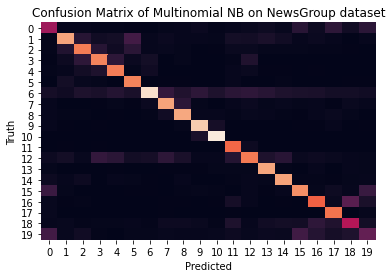

IMDB dataset 5-foldCV accuracy:  [0.8377542  0.84924845 0.86604775 0.83908046 0.82360743]
IMDB dataset 5-foldCV avg accuracy 0.8431476569407603
IMDB dataset testing accuracy:  0.84976


In [11]:
# Have to use 5-fold cross validation to estimate performance
model = MultinomialNB()
n = newsgroup_X_train_tfidf.shape[0]

# 20 news group dataset:
news_kfold_acc = kfoldCV(n, 5, newsgroup_X_train_tfidf, newsgroup_Y_train, model)
print(f'20 news dataset 5-foldCV accuracy: ', news_kfold_acc)
print(f'20 news dataset 5-foldCV avg accuracy', np.mean(news_kfold_acc))

model.fit(newsgroup_X_train_tfidf, newsgroup_Y_train)
newsgroup_Y_pred = model.predict(newsgroup_X_test_tfidf)
print(f'20 newsgroup dataset testing accuracy: ', evaluate_acc(newsgroup_Y_test, newsgroup_Y_pred)) # print accuracy

#confusion matrix
model.fit(newsgroup_X_train_tfidf, newsgroup_Y_train)
y_pred = model.predict(newsgroup_X_test_tfidf)
data = {'Predicted' : y_pred,
        'Truth ': newsgroup_Y_test}

df = pd.DataFrame(data, columns=['Predicted','Truth'])
cm = pd.crosstab( y_pred, newsgroup_Y_test)

sn.heatmap(cm, cbar=False)
plt.title("Confusion Matrix of Multinomial NB on NewsGroup dataset")
plt.ylabel('Truth')
plt.xlabel('Predicted')
plt.show()

# IMDB dataset:
IMDB_kfold_acc = kfoldCV(n, 5, IMDB_X_train_tfidf, IMDB_Y_train, model)
print(f'IMDB dataset 5-foldCV accuracy: ', IMDB_kfold_acc)
print(f'IMDB dataset 5-foldCV avg accuracy', np.mean(IMDB_kfold_acc))

model.fit(IMDB_X_train_tfidf, IMDB_Y_train)
IMDB_Y_pred = model.predict(IMDB_X_test_tfidf)
print(f'IMDB dataset testing accuracy: ', evaluate_acc(IMDB_Y_test, IMDB_Y_pred)) # print accuracy

### Task 3.2: 

In a single table, compare and report the performance of the performance of naive Bayes and logistic regression on each of the two datasets (with their best hyperparameters), and highlight the winner for each dataset and overall. You could find full hyper-parameters for logistic regression here.

In [12]:
# use 5-fold cross validation to estimate performance and find the best hyper-parameters

# estimate performance and find the best hyper-parameters of Multinomial NB 
alpha_list = [1.0e-10, 1, 5, 10, 30, 50, 100, 200]
NB_newsGroup_best_accuracy, NB_newsGroup_best_alpha = tuneNB(MultinomialNB, newsgroup_X_train_tfidf, newsgroup_Y_train, alpha_list)
print(f'NB_newsGroup_best_alpha: ', NB_newsGroup_best_alpha)
NB_IMDB_best_accuracy, NB_IMDB_best_alpha = tuneNB(MultinomialNB, IMDB_X_train_tfidf, IMDB_Y_train, alpha_list)
print(f'NB_IMDB_best_alpha: ', NB_IMDB_best_alpha)


# estimate performance and find the best hyper-parameters of Logistic regression 
# logistic regression model from sklearn
from sklearn.linear_model import LogisticRegression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# Change hyper-parameters and observe the performance on both dataset
lambda_list = [1, 0.5, 0.1, 0.01, 0.001] # smaller: stronger regularization
LR_newsGroup_best_accuracy, LR_newsGroup_best_lambda = tuneLR(LogisticRegression, newsgroup_X_train_tfidf, newsgroup_Y_train, lambda_list)
print(f'LR_newsGroup_best_lambda: ', LR_newsGroup_best_lambda)
LR_IMDB_best_accuracy, LR_IMDB_best_lambda = tuneLR(LogisticRegression, IMDB_X_train_tfidf, IMDB_Y_train, lambda_list)
print(f'LR_IMDB_best_lambda: ', LR_IMDB_best_lambda)


# Compare the testing performance of these two models on both datasets (with their best hyper-parameter):
resultTable = PrettyTable()
resultTable.title = "Best performance of MultinomialNB and Logistic Regression on both testing datasets"
resultTable.field_names = [" ", "20 news group", "IMDB"]
# calculate testing performance:
# NB newsgroup dataset:
NB_model = MultinomialNB(alpha = NB_newsGroup_best_alpha)
NB_model.fit(newsgroup_X_train_tfidf, newsgroup_Y_train)
newsgroup_Y_predicted = NB_model.predict(newsgroup_X_test_tfidf)
NB_newsGroup_best = evaluate_acc(newsgroup_Y_test, newsgroup_Y_predicted)

LR_model = LogisticRegression(penalty = 'l2', solver = 'sag', C = LR_newsGroup_best_lambda).fit(newsgroup_X_train_tfidf, newsgroup_Y_train)
newsgroup_Y_predicted = LR_model.predict(newsgroup_X_test_tfidf)
LR_newsGroup_best = evaluate_acc(newsgroup_Y_test, newsgroup_Y_predicted)

# IMDB dataset
NB_model = MultinomialNB(alpha = NB_IMDB_best_alpha)
NB_model.fit(IMDB_X_train_tfidf, IMDB_Y_train)
IMDB_Y_predicted = NB_model.predict(IMDB_X_test_tfidf)
NB_IMDB_best = evaluate_acc(IMDB_Y_test, IMDB_Y_predicted)

LR_model = LogisticRegression(penalty = 'l2', solver = 'sag', C = LR_IMDB_best_lambda).fit(IMDB_X_train_tfidf, IMDB_Y_train)
IMDB_Y_predicted = LR_model.predict(IMDB_X_test_tfidf)
LR_IMDB_best = evaluate_acc(IMDB_Y_test, IMDB_Y_predicted)

# print the table
resultTable.add_row(['MultinomialNB', NB_newsGroup_best, NB_IMDB_best])
resultTable.add_row(['Logistic Regression', LR_newsGroup_best, LR_IMDB_best])
print(resultTable)

NB_newsGroup_best_alpha:  30
NB_IMDB_best_alpha:  1e-10
LR_newsGroup_best_lambda:  0.1
LR_IMDB_best_lambda:  1
+----------------------------------------------------------------------------------+
| Best performance of MultinomialNB and Logistic Regression on both testing datasets |
+----------------------------------+--------------------------------+--------------+
|                                  |         20 news group          |     IMDB     |
+----------------------------------+--------------------------------+--------------+
|          MultinomialNB           |       0.6117896972915561       |   0.84976    |
|       Logistic Regression        |       0.6371481678173128       |    0.8776    |
+----------------------------------+--------------------------------+--------------+


### Task 3.3:

With a plot, compare the accuracy of the two models as a function of the size of dataset (by controlling the training size). For example, you can randomly select 20%, 40%, 60% and 80% of the available training data and train your model on this subset. Now, compare the performance of corresponding models and highlight the best.

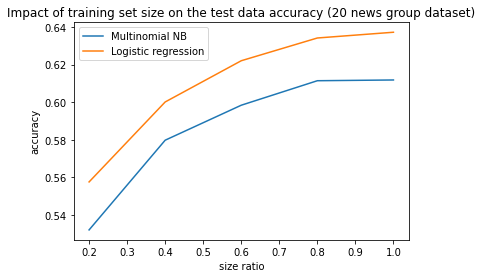

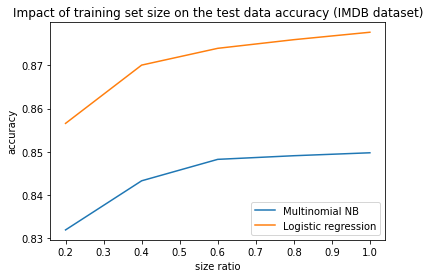

In [13]:
# Have to use cross-validation for calculate the average accuracy

# hyper-parameter list for tuning
alpha_list = [1.0e-10, 1, 5, 10, 30, 50, 100, 200]
lambda_list = [1, 0.5, 0.1, 0.01, 0.001] 
size_list = [0.2, 0.4, 0.6, 0.8, 1] # the size ratio of training dataset

# 20 news group dataset
NB_newsgroup_accuracy = []
LR_newsgroup_accuracy = []
for size_ratio in size_list:
    size = round(size_ratio * newsgroup_X_train_tfidf.shape[0])
    newsgroup_X_train_tfidf_reduced = newsgroup_X_train_tfidf[0:size, :]
    newsgroup_Y_train_reduced = newsgroup_Y_train[0:size]
    # Multinomial NB:
    NB_newsGroup_best_accuracy, NB_newsGroup_best_alpha = tuneNB(MultinomialNB, newsgroup_X_train_tfidf_reduced, newsgroup_Y_train_reduced, alpha_list)
    MNB_model = MultinomialNB(alpha = NB_newsGroup_best_alpha)
    MNB_model.fit(newsgroup_X_train_tfidf_reduced, newsgroup_Y_train_reduced) # feed x_train and y_train to the model
    newsgroup_Y_predicted = MNB_model.predict(newsgroup_X_test_tfidf)
    NB_newsgroup_accuracy.append(evaluate_acc(newsgroup_Y_test, newsgroup_Y_predicted))
    # Logistic Regression
    LR_newsGroup_best_accuracy, LR_newsGroup_best_lambda = tuneLR(LogisticRegression, newsgroup_X_train_tfidf_reduced, newsgroup_Y_train_reduced, lambda_list)
    LR_model = LogisticRegression(penalty = 'l2', solver = 'sag', C = LR_newsGroup_best_lambda).fit(newsgroup_X_train_tfidf_reduced, newsgroup_Y_train_reduced)
    newsgroup_Y_predicted = LR_model.predict(newsgroup_X_test_tfidf)
    LR_newsgroup_accuracy.append(evaluate_acc(newsgroup_Y_test, newsgroup_Y_predicted))

plt.plot(size_list, NB_newsgroup_accuracy, '-', label='Multinomial NB')
plt.plot(size_list, LR_newsgroup_accuracy, '-', label='Logistic regression')
plt.legend()
plt.title('Impact of training set size on the test data accuracy (20 news group dataset)')
plt.xlabel('size ratio')
plt.ylabel('accuracy')
plt.show()

# IMDB dataset
NB_IMDB_accuracy = []
LR_IMDB_accuracy = []
for size_ratio in size_list:
    size = round(size_ratio * IMDB_X_train_tfidf.shape[0])
    IMDB_X_train_tfidf_reduced = IMDB_X_train_tfidf[0:size, :]
    IMDB_Y_train_reduced = IMDB_Y_train[0:size]
    # Multinomial NB:
    NB_IMDB_best_accuracy, NB_IMDB_best_alpha = tuneNB(MultinomialNB, IMDB_X_train_tfidf_reduced, IMDB_Y_train_reduced, alpha_list)
    MNB_model = MultinomialNB(alpha = NB_IMDB_best_alpha)
    MNB_model.fit(IMDB_X_train_tfidf_reduced, IMDB_Y_train_reduced) # feed x_train and y_train to the model
    IMDB_Y_predicted = MNB_model.predict(IMDB_X_test_tfidf)
    NB_IMDB_accuracy.append(evaluate_acc(IMDB_Y_test, IMDB_Y_predicted))
    # Logistic Regression
    LR_IMDB_best_accuracy, LR_IMDB_best_lambda = tuneLR(LogisticRegression, IMDB_X_train_tfidf_reduced, IMDB_Y_train_reduced, lambda_list)
    LR_model = LogisticRegression(penalty = 'l2', solver = 'sag', C = LR_IMDB_best_lambda).fit(IMDB_X_train_tfidf_reduced, IMDB_Y_train_reduced)
    IMDB_Y_predicted = LR_model.predict(IMDB_X_test_tfidf)
    LR_IMDB_accuracy.append(evaluate_acc(IMDB_Y_test, IMDB_Y_predicted))

plt.plot(size_list, NB_IMDB_accuracy, '-', label='Multinomial NB')
plt.plot(size_list, LR_IMDB_accuracy, '-', label='Logistic regression')
plt.legend()
plt.title('Impact of training set size on the test data accuracy (IMDB dataset)')
plt.xlabel('size ratio')
plt.ylabel('accuracy')
plt.show()

### Creativity Part 1:
predict ratings for IMDB dataset instead of pos/neg using Linear Regression

In [14]:
IMDB_train_df_rating = pd.read_csv('./IMDB_training_rating.csv')
IMDB_test_df_rating = pd.read_csv('./IMDB_testing_rating.csv')

# ramdomize the data order
IMDB_train_df_rating = IMDB_train_df_rating.sample(frac=1).reset_index(drop=True)
IMDB_test_df_rating = IMDB_test_df_rating.sample(frac=1).reset_index(drop=True)
print(IMDB_train_df_rating)

# Data preprocessing order: raw data -> clean punctuation -> CountVectorizer to calculate word occurence -> tf–idf to calculate frequency -> TruncatedSVD to reduce dimensionality (LSA: latent semantic analysis) -> ready to use by model

# clean punctuation like: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
cleaner = str.maketrans('', '', string.punctuation)
IMDB_train_df_rating['Text'] = IMDB_train_df_rating['Text'].apply(lambda x : x.translate(cleaner)) 
IMDB_test_df_rating['Text'] = IMDB_test_df_rating['Text'].apply(lambda x : x.translate(cleaner)) 

# convert panda dataframe type to numpy array
array_train_IMDB_rating = IMDB_train_df_rating.to_numpy() # clean dataset in numpy array format
array_test_IMDB_rating = IMDB_test_df_rating.to_numpy()
IMDB_X_train_rating, IMDB_Y_train_rating = array_train_IMDB_rating[:,0], array_train_IMDB_rating[:,1].astype(int) # split the dataset to data and label
IMDB_X_test_rating, IMDB_Y_test_rating = array_test_IMDB_rating[:,0], array_test_IMDB_rating[:,1].astype(int) # split the dataset to data and label

# Convert the text data into numerical feature vector using CountVectorizer function
# (make word occurrence as features value)
CV = CountVectorizer()
IMDB_X_train_occurrence_rating = CV.fit_transform(IMDB_X_train_rating)
IMDB_X_test_occurrence_rating = CV.transform(IMDB_X_test_rating)

# Convert occurence to frequency (since longger documents (data) will have higher occurence of words)
# using tf–idf (“Term Frequency times Inverse Document Frequency”) which will convert occurrence of words to frequency and scale down the impact of words that occur very frequently in a given corpus that are less informative (Ex: "is", "it", "a", "the", etc)
IMBD_tfidf_transformer = TfidfTransformer(use_idf=True)
# fit the transformer to our data and transform our occurrence data matrix to tfidf matrix
IMDB_X_train_tfidf_rating = IMBD_tfidf_transformer.fit_transform(IMDB_X_train_occurrence_rating)
IMDB_X_test_tfidf_rating = IMBD_tfidf_transformer.transform(IMDB_X_test_occurrence_rating)

# use SVD to do dimensionality reduction (LSA: latent semantic analysis)
svd = TruncatedSVD(n_components=500, n_iter=7, random_state=77) 
IMDB_X_train_tfidf_rating = svd.fit_transform(IMDB_X_train_tfidf_rating)
IMDB_X_test_tfidf_rating = svd.transform(IMDB_X_test_tfidf_rating)

# Scale word frequency to [0,1], since negative value cannot be feed to MultinomialNB
# The output of scaler.transform() will be nparray
scaler = MinMaxScaler()
IMDB_X_train_tfidf_rating = scaler.fit_transform(IMDB_X_train_tfidf_rating)
IMDB_X_test_tfidf_rating = scaler.transform(IMDB_X_test_tfidf_rating)

                                                    Text  Label
0      This very peculiar setting of Wagner's last op...      9
1      I should say right away that I checked the spo...      1
2      This picture reminds me of a Keneth More pictu...      3
3      First and foremost, Zorie Barber (Zeke), might...      1
4      Noni Hazlehurst, Colin Friels, Alice Garner, C...     10
...                                                  ...    ...
24995  Ed Harris's work in this film is up to his usu...      7
24996  A LAUREL & HARDY Comedy Short. The Boys arrive...     10
24997  First of all I am a butch, straight white male...     10
24998  Barriers seems to be one of those series that ...      9
24999  This should be required viewing for all young ...     10

[25000 rows x 2 columns]


In [15]:
# Linear Regression to predict rating for IMDB dataset
#LR_model = LogisticRegression(max_iters = 1000).fit(IMDB_X_train_tfidf_rating, IMDB_Y_train_rating)
from sklearn.linear_model import LinearRegression
# LR_model = LogisticRegression(random_state=0, penalty = 'l2', solver = 'saga', max_iter = 100).fit(IMDB_X_train_tfidf_rating, IMDB_Y_train_rating)
LR_model = LinearRegression().fit(IMDB_X_train_tfidf_rating, IMDB_Y_train_rating)
IMDB_Y_predicted = LR_model.predict(IMDB_X_test_tfidf_rating)
IMDB_Y_predicted = np.rint(IMDB_Y_predicted) # round the prediction of ratings to nearest int
print(f'IMDB rating prediction accuracy: ', evaluate_acc(IMDB_Y_test_rating, IMDB_Y_predicted))

IMDB rating prediction accuracy:  0.17012


### Creativity Part 2:
try to use words bag for prediction instead of words frequency and observe the performance difference

In [18]:
MNB_model = MultinomialNB()
# news group dataset:
news_kfold_acc = kfoldCV(n, 5, newsgroup_X_train_occurrence, newsgroup_Y_train, MNB_model)
print(f'20 news dataset 5-foldCV accuracy: ', news_kfold_acc)
print(f'20 news dataset 5-foldCV avg accuracy', np.mean(news_kfold_acc))

MNB_model.fit(newsgroup_X_train_occurrence, newsgroup_Y_train)
newsgroup_Y_pred = MNB_model.predict(newsgroup_X_test_occurrence)
print(f'20 newsgroup dataset testing accuracy: ', evaluate_acc(newsgroup_Y_test, newsgroup_Y_pred)) # print accuracy


MNB_model = MultinomialNB()
# IMDB dataset:
IMDB_kfold_acc = kfoldCV(n, 5, IMDB_X_train_occurrence, IMDB_Y_train, model)
print(f'IMDB dataset 5-foldCV accuracy: ', IMDB_kfold_acc)
print(f'IMDB dataset 5-foldCV avg accuracy', np.mean(IMDB_kfold_acc))

model.fit(IMDB_X_train_occurrence, IMDB_Y_train)
IMDB_Y_pred = model.predict(IMDB_X_test_occurrence)
print(f'IMDB dataset testing accuracy: ', evaluate_acc(IMDB_Y_test, IMDB_Y_pred)) # print accuracy

20 news dataset 5-foldCV accuracy:  [0.57559682 0.57736516 0.5495137  0.57869142 0.55393457]
20 news dataset 5-foldCV avg accuracy 0.5670203359858532
20 newsgroup dataset testing accuracy:  0.5428836962294211
IMDB dataset 5-foldCV accuracy:  [0.83333333 0.84261715 0.84615385 0.83554377 0.84350133]
IMDB dataset 5-foldCV avg accuracy 0.8402298850574713
IMDB dataset testing accuracy:  0.8172


### Creativity Part 3:

The effect of n-grams on accuracy

In [21]:
#N-GRAMS USING TFID BAG OF WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
model = MultinomialNB()

vectorizer = CountVectorizer(ngram_range=(1,2)) 
newsgroup_tfidf_ngram_train = vectorizer.fit_transform(newsgroup_X_train)
print(f'20 news 5-fold accuracy with ngram range 1,2: ', kfoldCV(n, 5, newsgroup_tfidf_ngram_train, newsgroup_Y_train, model))

model = MultinomialNB()
vectorizer = CountVectorizer(ngram_range=(2,2)) 
newsgroup_tfidf_ngram_train = vectorizer.fit_transform(newsgroup_X_train)
print(f'20 news 5-fold accuracy with ngram range 2,2: ', kfoldCV(n, 5, newsgroup_tfidf_ngram_train, newsgroup_Y_train, model))

model = MultinomialNB()
vectorizer = CountVectorizer(ngram_range=(1,3)) 
newsgroup_tfidf_ngram_train = vectorizer.fit_transform(newsgroup_X_train)
print(f'20 news 5-fold accuracy with ngram range 1,3: ', kfoldCV(n, 5, newsgroup_tfidf_ngram_train, newsgroup_Y_train, model))


20 news 5-fold accuracy with ngram range 1,2:  [0.49867374 0.49646331 0.45269673 0.47833775 0.45755968]
20 news 5-fold accuracy with ngram range 2,2:  [0.51149425 0.52122016 0.47701149 0.49381079 0.50044209]
20 news 5-fold accuracy with ngram range 1,3:  [0.50176835 0.49823165 0.46286472 0.48143236 0.46905393]


In [25]:
#N-GRAMS
from sklearn.feature_extraction.text import TfidfVectorizer
model = MultinomialNB()

vectorizer = CountVectorizer(ngram_range=(1,2)) 
IMDB_tfidf_ngram_train = vectorizer.fit_transform(IMDB_X_train)
print(f'IMDB 5-fold accuracy with ngram range 1,2: ', kfoldCV(n, 5, IMDB_tfidf_ngram_train, IMDB_Y_train, model))
print(f'IMDB 5-fold avg accuracy with ngram range 1,2: ', np.mean(kfoldCV(n, 5, IMDB_tfidf_ngram_train, IMDB_Y_train, model)))

model = MultinomialNB()
vectorizer = CountVectorizer(ngram_range=(2,2)) 
IMDB_tfidf_ngram_train = vectorizer.fit_transform(IMDB_X_train)
print(f'IMDB 5-fold accuracy with ngram range 2,2: ', kfoldCV(n, 5, IMDB_tfidf_ngram_train, IMDB_Y_train, model))
print(f'IMDB 5-fold avg accuracy with ngram range 2,2: ', np.mean(kfoldCV(n, 5, IMDB_tfidf_ngram_train, IMDB_Y_train, model)))

model = MultinomialNB()
vectorizer = CountVectorizer(ngram_range=(1,3)) 
IMDB_tfidf_ngram_train = vectorizer.fit_transform(IMDB_X_train)
print(f'IMDB 5-fold accuracy with ngram range 1,3: ', kfoldCV(n, 5, IMDB_tfidf_ngram_train, IMDB_Y_train, model))
print(f'IMDB 5-fold avg accuracy with ngram range 1,3: ', np.mean(kfoldCV(n, 5, IMDB_tfidf_ngram_train, IMDB_Y_train, model)))

IMDB 5-fold accuracy with ngram range 1,2:  [0.86206897 0.87798408 0.88107869 0.86781609 0.87135279]
IMDB 5-fold avg accuracy with ngram range 1,2:  0.8720601237842617
IMDB 5-fold accuracy with ngram range 2,2:  [0.8642794  0.87488948 0.88019452 0.8709107  0.877542  ]
IMDB 5-fold avg accuracy with ngram range 2,2:  0.8735632183908046
IMDB 5-fold accuracy with ngram range 1,3:  [0.87179487 0.88284704 0.88682582 0.87533156 0.87886826]
IMDB 5-fold avg accuracy with ngram range 1,3:  0.8791335101679929
